Exploration of Data

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gp
import pyspark.sql.functions as F
from pyspark import SparkContext
from pyspark.sql import SQLContext
from datetime import datetime

In [82]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

In [2]:
dt=np.dtype([('id',np.ulonglong),('start year',np.short),('start month',np.byte),('start day',np.byte),('start hour',np.byte),('start minute',np.byte),('start julian',np.double),('end year',np.short),('end month',np.byte),('end day',np.byte),('end hour',np.byte),('end minute',np.byte),('trip seconds',np.uint32),('trip miles',np.single),('pickup census tract',np.ulonglong),('dropoff census tract',np.ulonglong),('pickup community area',np.byte),('dropoff community area',np.byte),('fare',np.single),('tip',np.single),('addcharge',np.single),('trip total',np.single),('st auth',np.byte),('pool',np.byte),('pickup lat',np.double),('pickup lon',np.double),('dropoff lat',np.double),('dropoff lon',np.double)])

In [3]:
sc = SparkContext('local[*]','temp')
sqlContext=SQLContext(sc)

22/07/25 20:38:43 WARN Utils: Your hostname, benjamin-precision resolves to a loopback address: 127.0.0.2, but we couldn't find any external IP address!
22/07/25 20:38:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/07/25 20:38:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/07/25 20:38:43 WARN MacAddressUtil: Failed to find a usable hardware address from the network interfaces; using random bytes: 48:22:a9:b1:7b:45:3a:da
22/07/25 20:38:44 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [84]:
dt=np.dtype([('id',np.ulonglong),('start year',np.short),('start month',np.byte),('start day',np.byte),('start hour',np.byte),('start minute',np.byte),('start julian',np.double),('end year',np.short),('end month',np.byte),('end day',np.byte),('end hour',np.byte),('end minute',np.byte),('trip seconds',np.uint32),('trip miles',np.single),('pickup census tract',np.ulonglong),('dropoff census tract',np.ulonglong),('pickup community area',np.byte),('dropoff community area',np.byte),('fare',np.single),('tip',np.single),('addcharge',np.single),('trip total',np.single),('st auth',np.byte),('pool',np.byte),('pickup lat',np.double),('pickup lon',np.double),('dropoff lat',np.double),('dropoff lon',np.double)])

def read_array(x):
    array=np.frombuffer(bytes(x),dtype=dt)
    return array.tolist()[0]

def read_in_range(start_year,start_month,end_year,end_month,path='/media/benjamin/Data/Chicago_Transit/TNP/'):
    dt=np.dtype([('id',np.ulonglong),('start year',np.short),('start month',np.byte),('start day',np.byte),('start hour',np.byte),('start minute',np.byte),('start julian',np.double),('end year',np.short),('end month',np.byte),('end day',np.byte),('end hour',np.byte),('end minute',np.byte),('trip seconds',np.uint32),('trip miles',np.single),('pickup census tract',np.ulonglong),('dropoff census tract',np.ulonglong),('pickup community area',np.byte),('dropoff community area',np.byte),('fare',np.single),('tip',np.single),('addcharge',np.single),('trip total',np.single),('st auth',np.byte),('pool',np.byte),('pickup lat',np.double),('pickup lon',np.double),('dropoff lat',np.double),('dropoff lon',np.double)])
    
    #Calculate month and year ranges
    nmonths=(end_year-start_year-1)*12.+(12.-start_month+1)+end_month
    yrs=(start_year+np.floor((start_month+np.arange(0,nmonths)-1)/12.)).astype(int)
    mos=(np.floor((np.mod(start_month+np.arange(nmonths)-1,12)+1 ))).astype(int)
    
    #construct list of file names
    fnames=''
    if nmonths > 1:
        for i in np.arange(0,nmonths,dtype=np.int16):
            fnames+=(path+"{0:04d}{1:02d}".format(yrs[i],mos[i])+'TNP.dat')
            if i != nmonths-1:
                fnames+=','
    else:
        fnames=path+"{0:04d}{1:02d}".format(yrs,mos)+'TNP.dat'
        
    #load binary records into rdd given record length
    rdd=sc.binaryRecords(fnames,104)
    out=rdd.map(read_array)
    df=out.toDF(['id','start year','start month','start day','start hour','start minute','start julian','end year','end month','end day','end hour','end minute','trip seconds','trip miles','pickup census tract','dropoff census tract','pickup community area','dropoff community area','fare','tip','addcharge','trip total','st auth','pool','pickup lat','pickup lon','dropaff lat','dropoff lon'])
    out.unpersist()
    return df

def area_out(df,ca,to_pandas=True):
    with_out=df.groupby(['start year','start month','start day','start hour','start julian','pickup community area']).count()
    out_area=with_out.where(with_out['pickup community area']==ca)
    out_area_sort=out_area.sort(['start year','start month','start day','start hour'])
    if to_pandas:
        outdf=out_area_sort.toPandas()
        outdf=outdf.rename(columns={'start year':'year','start month':'month','start day':'day','start hour':'hour'})
    else:
        outdf=out_area_sort.withColumnRenamed('start year','year').withColumnRenamed('start month','month').withColumnRenamed('start day','day').withColumnRenamed('start hour','hour')
    return outdf

def one_time_count(df,yr,mo,dy,hr):
        one_time=df.where((df['start year']==yr) & (df['start month']==mo) & (df['start day']==dy) & (df['start hour']==hr))
        cnt=one_time.groupby(['pickup community area']).count().toPandas()
        return cnt
    
def plot_chicago(counts):
    #expects geopandas dataframe with chicago boundary information
    #and counts as a pandas dataframe
    chicago=gp.read_file('/media/benjamin/Data/Chicago_Transit/Shapes/geo_export_43aec312-120e-4284-b1ca-b89761679d63.shp')
    chicago['pickup community area']=chicago['area_num_1'].astype(np.int32)
    with_count=chicago.merge(counts,on='pickup community area',how='left')
    fix, ax = plt.subplots(1,1) 
    with_count.plot(column='count',ax=ax,legend=True,legend_kwds={'label':'Pickup Count'})
    return with_count

def get_coefficients(counts):
    
    to_fit=counts.withColumn('twhrsine',F.sin(2*3.14159*F.col('start julian')*2.)).withColumn('twhrcos',F.cos(2*3.14159*F.col('start julian')*2.)).withColumn('daysine',F.sin(2*3.14159*F.col('start julian'))).withColumn('daycos',F.cos(2*3.14159*F.col('start julian'))).withColumn('weeksine',F.sin(2*3.14159*F.col('start julian')/7.)).withColumn('weekcos',F.cos(2*3.14159*F.col('start julian')/7.))
    va=VectorAssembler(inputCols = ['twhrsine','twhrcos','daysine','daycos','weeksine','weekcos'],outputCol = 'features')
    lr=LinearRegression(regParam=0.1)
    va_to_fit = va.transform(to_fit)
    final = va_to_fit.selectExpr(['features','count as label'])
    lr_model=lr.fit(final)
    return lr_model

Reads all the data into a spark dataframe

In [9]:
df=read_in_range(2018,11,2022,5)

Makes a pandas dataframe containing hourly counts of all rides originating in the Chicago Loop (community area 32).

In [10]:
out32=area_out(df,32)

22/07/25 20:51:08 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


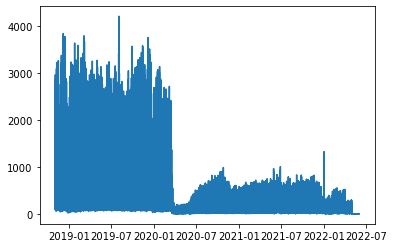

In [18]:
plt.plot(pd.to_datetime(out32[['year','month','day','hour']]),out32['count'])

Time series plot showing hourly counts of rides originating in the loop over the whole reporting range. Several features stand out. The first is the step-function-like change from pre- to post-pandemic behavior. This suggests that traning a model on the whole data set for future predictions is not a good idea -- behavior in September 2019 probably has little bearing on behavior in September 2022.

Second are the very low counts in the several months prior to the data being collected. This is due to the lag in reporting from TNP companies to the City of Chicago. The lag is variable, but after about 3 months almost all rides have been reported. I exlude April, May, and June of 2022 from this analysis.

Based on this time series, I tentatively restrict the analysis region to June 2020 to March 2022, and redo the above calculations.

In [19]:
df=read_in_range(2020,6,2022,3)

In [20]:
out32=area_out(df,32)

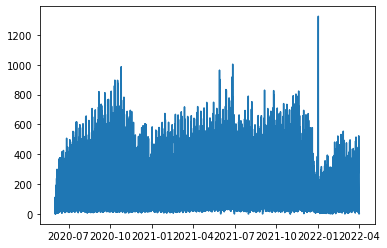

In [21]:
plt.plot(pd.to_datetime(out32[['year','month','day','hour']]),out32['count'])

With this restricted range, the data appear somewhat more regular, although there is cleally still a lot of variability. Zooming in on June 2021 offers some insight into the nature of the ridership patters here.

(18779.0, 18808.0)

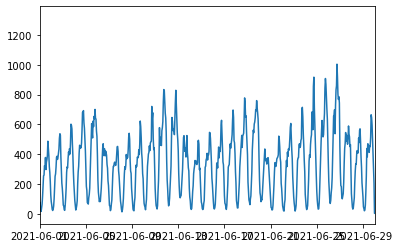

In [22]:
plt.plot(pd.to_datetime(out32[['year','month','day','hour']]),out32['count'])
plt.xlim([datetime(2021,6,1),datetime(2021,6,30)])

Here we clearly see the periodic nature of the ridership patters. A daily pattern stands out most clearly, as well as a well as a weekly pattern. Zooming in further shows evidence of more structure in the daily pattern, such as a dip in rides in the middle of the day.

I next look at the periodic nature of this data by computing the Fourier Transform of the data.

In [23]:
fft=np.fft.fft(out32['count']-np.mean(out32['count']))

(0.0, 1000.0)

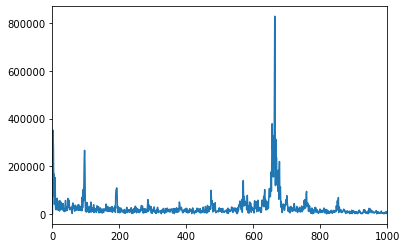

In [39]:
plt.plot(np.abs(fft))
plt.xlim([0,1000])

In [40]:
15936/24

664.0

The periodicity is clearly reflected in the fourier transform, which spans 664 days. 

In [28]:
fft.size/24

15936

(0.0, 5.0)

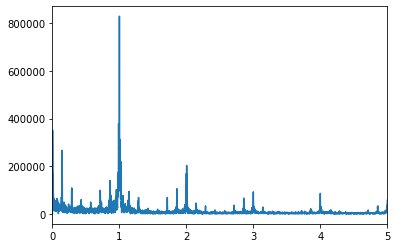

In [44]:
plt.plot(np.arange(0,15936)/664.,np.abs(fft))
plt.xlim([0,5])

Here the fft has been plotted with units of day^-1 on the x-axis. Clearly the daily cycle is the strongest, followed by the weekly cycle, and the bi-daily cycle. There is a significant amount of power in side-modes and harmonics, which likely reflects some amount of real signal and distortion of the sinusoid, especially due to the positive definite nature of the count variable.

The amount of power in these three nodes suggests that a Fourier model would be a good choice for a base model.

Next I turn to displaying the data in a Chloropleth map of Chicago in order to perform some basic sanity checks.

In [78]:
mid_june=one_time_count(df,2021,6,13,17)

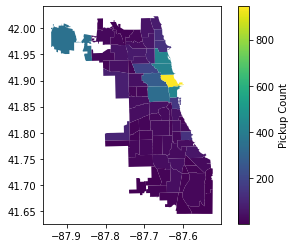

In [79]:
jplot=plot_chicago(mid_june)

This is a plausible map for mid-june, with most activity being around the loop, the near north side, and O'Hare. I'm surprised I don't see midway on this map.

Last, I test the method fitting method suggested by the Fourier Transforms above. This model fits sinusoids with 12 hour, 1 day, and 1 week periods to the data, with the intent of using these fits as predictors of future behavior.

In [80]:
df=read_in_range(2021,8,2021,9)

In [81]:
cnt=area_out(df,32,to_pandas=False)

In [85]:
model=get_coefficients(cnt)

22/07/26 11:36:52 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/07/26 11:36:52 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/07/26 11:36:52 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/07/26 11:36:52 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [101]:
coeffs=list(model.coefficients)
intercept=model.intercept
p_cnt=area_out(df,32)

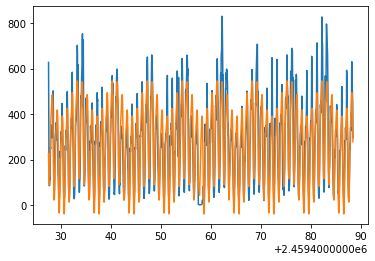

In [103]:
plt.plot(p_cnt['start julian'],p_cnt['count'])
plt.plot(p_cnt['start julian'],coeffs[0]*np.sin(2.*3.14159*p_cnt['start julian']*2.)+coeffs[1]*np.cos(2.*3.14159*p_cnt['start julian']*2.)+coeffs[2]*np.sin(2.*3.14159*p_cnt['start julian'])+coeffs[3]*np.cos(2.*3.14159*p_cnt['start julian'])+coeffs[4]*np.sin(2.*3.14159*p_cnt['start julian']/7.)+coeffs[5]*np.cos(2.*3.14159*p_cnt['start julian']/7)+intercept)
#plt.xlim([2459500,2459540])

This plot shows hourly loop counts in blue, and the model fit in orange.

(2459440.0, 2459454.0)

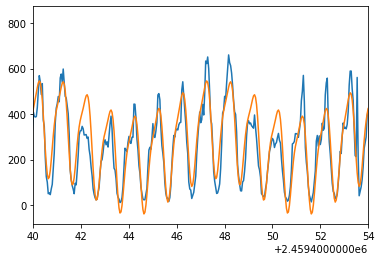

In [107]:
plt.plot(p_cnt['start julian'],p_cnt['count'])
plt.plot(p_cnt['start julian'],coeffs[0]*np.sin(2.*3.14159*p_cnt['start julian']*2.)+coeffs[1]*np.cos(2.*3.14159*p_cnt['start julian']*2.)+coeffs[2]*np.sin(2.*3.14159*p_cnt['start julian'])+coeffs[3]*np.cos(2.*3.14159*p_cnt['start julian'])+coeffs[4]*np.sin(2.*3.14159*p_cnt['start julian']/7.)+coeffs[5]*np.cos(2.*3.14159*p_cnt['start julian']/7)+intercept)
plt.xlim([2459440,2459454])

Same as above, but zoomed into a 2-week period. Much of the variability is capture by the three frequencies.

In [108]:
resid=p_cnt['count']-(coeffs[0]*np.sin(2.*3.14159*p_cnt['start julian']*2.)+coeffs[1]*np.cos(2.*3.14159*p_cnt['start julian']*2.)+coeffs[2]*np.sin(2.*3.14159*p_cnt['start julian'])+coeffs[3]*np.cos(2.*3.14159*p_cnt['start julian'])+coeffs[4]*np.sin(2.*3.14159*p_cnt['start julian']/7.)+coeffs[5]*np.cos(2.*3.14159*p_cnt['start julian']/7)+intercept)

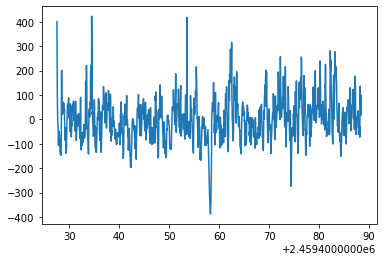

In [109]:
plt.plot(p_cnt['start julian'],resid)

Residuals for the region above. There is still periodic structure, but now noise and 1-off events are much more visible. This could serve as a reasonable base model, although we have not yet grappled with seasonal effects, variations due to covid policy, etc.